In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 16 16:00:33 2020

@author: Niels Focke
"""
from __future__ import print_function
from ortools.graph import pywrapgraph
import time
import os
import random as rng
import multiprocessing as mp
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__
import networkx as nx

In [10]:
start_time = time.process_time()

#initialise graph
G = ox.graph.graph_from_point([50.77543745,6.083803247551902],dist=3000,network_type='drive')
G = nx.convert_node_labels_to_integers(G)
node_info = G.nodes



#number of entities
carrier_number = 10#rng.randint(100,200)
transportable_number = 10#rng.randint(100,200)


#functions to select random nodes
def create_random_node_points(number,Graph):
    node_list=[]
    for i in range(number):
        node_list.append(rng.randint(0,len(list(node_info))-1))
    return node_list



In [11]:
#create random carriers and transportables
carriers = create_random_node_points(carrier_number,G)
transportables = create_random_node_points(transportable_number,G)


#find paths from carriers to transportables
node_info = node_info
route_list = []
weight_list = []

connection_list = []
connection_number = []
end_list = []

for i in range(len(carriers)):
    ways_to_transportables = []
    end_numbers = []
    counter=0
    for j in range(len(transportables)):
        if (ox.distance.euclidean_dist_vec(node_info[carriers[i]]['y'],node_info[carriers[i]]['x'],
                                           node_info[transportables[j]]['y'],node_info[transportables[j]]['x'])) <= 1:#euclidian distance is in lng,lat degrees
            #print(ox.distance.euclidean_dist_vec(node_info[carriers[i]]['y'],node_info[carriers[i]]['x'],
            #                               node_info[transportables[j]]['y'],node_info[transportables[j]]['x']))
            connection_list.append(j+1+carrier_number)
            end_numbers.append(j)
            way = ox.shortest_path(G, carriers[i], transportables[j], weight='length')
            ways_to_transportables.append(way)
            way_weight=0
            for k in range(len(way)-1):
                way_weight += G[way[k]][way[k+1]][0]['length']
            weight_list.append(way_weight)
            counter+=1
    
    end_list.append(end_numbers)
    connection_number.append(counter)
    route_list.append(ways_to_transportables)
    


print("Time =", time.process_time() - start_time, "seconds")

Time = 6.484008211999999 seconds


In [19]:
def main(n_carrier,n_transportables,weights,connections,n_connections):
  """Solving an Assignment Problem with MinCostFlow"""

  # Instantiate a SimpleMinCostFlow solver.
  min_cost_flow = pywrapgraph.SimpleMinCostFlow()

  # Define the directed graph for the flow.
  start_nodes = np.zeros(n_carrier)
  for i in range(n_carrier):
      start_nodes = np.concatenate((start_nodes , np.full(n_connections[i],i+1)))
  start_nodes = np.concatenate((start_nodes , np.linspace(n_carrier+1,n_carrier+n_transportables,n_transportables)))
  
  end_nodes = np.linspace(1,n_carrier,n_carrier)
  end_nodes = np.concatenate((end_nodes , connections))
  end_nodes = np.concatenate((end_nodes , np.full(n_transportables,n_carrier+n_transportables+1)))
      
  capacities = np.zeros(n_carrier+sum(n_connections)+n_transportables)+1

  costs = np.concatenate((np.zeros(n_carrier), weight_list, np.zeros(n_transportables)))

  start_nodes = start_nodes.astype(int)
  end_nodes = end_nodes.astype(int)
  capacities = capacities.astype(int)
  costs = costs.astype(int)
  
  start_nodes = start_nodes.tolist()
  end_nodes = end_nodes.tolist()
  capacities = capacities.tolist()
  costs = costs.tolist()

  source = 0
  sink = n_carrier+n_transportables+1
  tasks = n_transportables
  
  supplies = np.concatenate(([min(n_carrier,n_transportables)], np.zeros(n_carrier+n_transportables),[-min(n_carrier,n_transportables)]))
  supplies = supplies.astype(int)
  supplies = supplies.tolist()

  # Add each arc.
  for i in range(len(start_nodes)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],capacities[i], costs[i])
  # Add node supplies.

  for i in range(len(supplies)):
    min_cost_flow.SetNodeSupply(i, supplies[i])

  # Find the minimum cost flow between node 0 and node 10.
  
  print('Solve: ', min_cost_flow.Solve())
  print('Optimal: ', min_cost_flow.OPTIMAL)
  print('Num_Arcs: ', min_cost_flow.NumArcs())
  output = []
  if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
    print('Total cost = ', min_cost_flow.OptimalCost())
    print()
    for arc in range(min_cost_flow.NumArcs()):

      # Can ignore arcs leading out of source or into sink.
      if min_cost_flow.Tail(arc)!=source and min_cost_flow.Head(arc)!=sink:

        # Arcs in the solution have a flow value of 1. Their start and end nodes
        # give an assignment of worker to task.

        if min_cost_flow.Flow(arc) > 0:
          print('Carrier %d assigned to transportable %d.  Cost = %d' % (
                min_cost_flow.Tail(arc),
                min_cost_flow.Head(arc)-n_carrier,
                min_cost_flow.UnitCost(arc)))
          output.append([min_cost_flow.Tail(arc),min_cost_flow.Head(arc)])
  else:
    print('There was an issue with the min cost flow input.')
  
  return output

In [20]:
if __name__ == '__main__':
  
  optimal_routes=main(carrier_number,transportable_number,weight_list,connection_list,connection_number)
  print()
  print("Time =", time.process_time() - start_time, "seconds")
  print()
  #print(optimal_routes)

Solve:  1
Optimal:  1
Num_Arcs:  440
Total cost =  27312

Carrier 1 assigned to transportable 19.  Cost = 1457
Carrier 2 assigned to transportable 15.  Cost = 932
Carrier 3 assigned to transportable 13.  Cost = 1308
Carrier 4 assigned to transportable 16.  Cost = 824
Carrier 5 assigned to transportable 2.  Cost = 378
Carrier 6 assigned to transportable 12.  Cost = 2411
Carrier 7 assigned to transportable 8.  Cost = 3796
Carrier 8 assigned to transportable 5.  Cost = 335
Carrier 9 assigned to transportable 6.  Cost = 1753
Carrier 10 assigned to transportable 11.  Cost = 409
Carrier 11 assigned to transportable 7.  Cost = 973
Carrier 12 assigned to transportable 18.  Cost = 1407
Carrier 13 assigned to transportable 10.  Cost = 1648
Carrier 14 assigned to transportable 1.  Cost = 801
Carrier 15 assigned to transportable 4.  Cost = 2574
Carrier 16 assigned to transportable 9.  Cost = 1905
Carrier 17 assigned to transportable 17.  Cost = 369
Carrier 18 assigned to transportable 20.  Cost = 

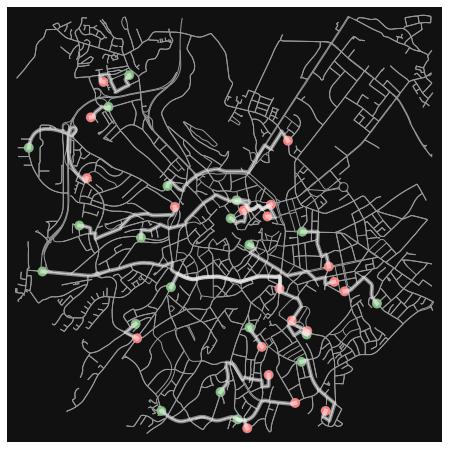

Time = 11.581179657 seconds


<Figure size 432x288 with 0 Axes>

In [21]:
#plotting routine
color_list=['r','b','g','y']
#color_list=['C00','C01','C02','C03','C04','C05']

nc=[]
ns=[]
for node in G.nodes():
    if node in carriers:
        nc.append('r')
        ns.append(80)
    elif node in transportables:
        nc.append('g')
        ns.append(80)
    else:
        nc.append('w')
        ns.append(0)
        
routes_to_plot = []
for element in optimal_routes:
    routes_to_plot.append(route_list[element[0]-1][end_list[element[0]-1].index(element[1]-carrier_number-1)])

ox.plot.plot_graph_routes(G,routes_to_plot,route_colors='w', show=True, close=False, node_color=nc, node_size=ns)

plt.savefig('graph')




print("Time =", time.process_time() - start_time, "seconds")



In [27]:
start_time = time.process_time()
#initialise graph
G = ox.graph.graph_from_point([50.77543745,6.083803247551902],dist=3000,network_type='drive')
G = nx.convert_node_labels_to_integers(G)
node_info = G.nodes
#number of entities
carrier_number = 10#rng.randint(100,200)
transportable_number = 10#rng.randint(100,200)


#functions to select random nodes
def create_random_node_points(number,Graph):
    node_list=[]
    for i in range(number):
        node_list.append(rng.randint(0,len(list(node_info))-1))
    return node_list


#create random carriers and transportables
carriers = create_random_node_points(carrier_number,G)
transportables = create_random_node_points(transportable_number,G)

print(carriers)
print(transportables)

[1427, 108, 976, 427, 1260, 1013, 1377, 779, 628, 815]
[47, 458, 1280, 1561, 72, 49, 637, 853, 1491, 196]


In [6]:
carriers = [1427, 108, 976, 427, 1260, 1013, 1377, 779, 628, 815]
transportables = [47, 458, 1280, 1561, 72, 49, 637, 853, 1491, 196]

In [22]:

n_carrier = len(carriers)
n_transportables = len(transportables)

min_cost_flow = pywrapgraph.SimpleMinCostFlow()
#       min_cost_flow = pywrapgraph.GenericMinCostFlow()
#       min_cost_flow = pywrapgraph.MinCostFlowBase()
#       min_cost_flow = pywrapgraph.MinCostFlow()

# Define the directed graph for the flow.
start_nodes = np.zeros(n_carrier)
# print(start_nodes)
for i in range(n_carrier):
    start_nodes = np.concatenate((start_nodes , np.full(n_connections[i],i+1)))
# print(start_nodes)
start_nodes = np.concatenate((start_nodes , np.linspace(n_carrier+1,n_carrier+n_transportables,n_transportables)))
# print(start_nodes)

end_nodes = np.linspace(1,n_carrier,n_carrier)
print(end_nodes)
end_nodes = np.concatenate((end_nodes , connections))
print(end_nodes)
end_nodes = np.concatenate((end_nodes , np.full(n_transportables,n_carrier+n_transportables+1)))

capacities =np.zeros(n_carrier+sum(n_connections)+n_transportables)+1
print('capacities',capacities)

costs = np.concatenate((np.zeros(n_carrier), weight_list, np.zeros(n_transportables)))

print(start_nodes)

start_nodes = start_nodes.astype(int)

print(start_nodes)

end_nodes = end_nodes.astype(int)
capacities = capacities.astype(int)
costs = costs.astype(int)

start_nodes = start_nodes.tolist()
end_nodes = end_nodes.tolist()
capacities = capacities.tolist()
costs = costs.tolist()

source = 0
sink = n_carrier+n_transportables+1
tasks = n_transportables

supplies = np.concatenate(([min(n_carrier,n_transportables)], np.zeros(n_carrier+n_transportables),[-min(n_carrier,n_transportables)]))
supplies = supplies.astype(int)
supplies = supplies.tolist()

# Add each arc.
for i in range(len(start_nodes)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],capacities[i], costs[i])
# Add node supplies.

for i in range(len(supplies)):
    min_cost_flow.SetNodeSupply(i, supplies[i])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 11. 12. 13. 14.
 15. 16. 17. 18. 19. 20. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
capacities [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.

In [16]:
n_connections = connection_number
connections = connection_list